# Time series clustering exercise

Python 3

In [1]:
from __future__ import print_function 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import geopandas as gpd
from fiona.crs import from_epsg
import shapely
import urllib.request
import requests
import json
from io import StringIO
import io
import zipfile
from sklearn import cluster
from sklearn.metrics import silhouette_score
import matplotlib.patches as mpatches
import scipy.cluster.hierarchy as sch

## 1. Data

Download the census bureau business data for all years 1994-2014.

In [2]:
#these commands can be run on the shell and get the data with the command wget
#the cell needs to be run only once
!for ((y=94; y<=99; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp$y\totals.zip; mv \
zbp$y\totals.zip $PUIDATA; done

!for ((y=0; y<=1; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp0$y\totals.zip; mv \
zbp0$y\totals.zip $PUIDATA; done

!for ((y=2; y<=9; y+=1)); do wget \
https://www2.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; mv \
zbp0$y\totals.zip $PUIDATA; done

!for ((y=10; y<=14; y+=1)); do wget \
https://www2.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; mv \
zbp$y\totals.zip $PUIDATA; done

--2017-12-13 02:53:08--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp94totals.zip
Resolving www2.census.gov... 104.99.148.110, 2600:1408:1d:38b::208c, 2600:1408:1d:386::208c
Connecting to www2.census.gov|104.99.148.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611524 (597K) [application/zip]
Saving to: 'zbp94totals.zip'

zbp94totals.zip     100%[===================>] 597.19K  --.-KB/s    in 0.1s    

2017-12-13 02:53:09 (5.39 MB/s) - 'zbp94totals.zip' saved [611524/611524]

--2017-12-13 02:53:09--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp95totals.zip
Resolving www2.census.gov... 104.99.148.110, 2600:1408:1d:38b::208c, 2600:1408:1d:386::208c
Connecting to www2.census.gov|104.99.148.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625328 (611K) [application/zip]
Saving to: 'zbp95totals.zip'

zbp95totals.zip     100%[===================>] 610.67K  --.-KB/s    in 0.1s    

2017-12-13 02:53:09 (5.89 M

zbp09totals.zip     100%[===================>] 644.64K  --.-KB/s    in 0.1s    

2017-12-13 02:53:12 (6.33 MB/s) - 'zbp09totals.zip' saved [660109/660109]

--2017-12-13 02:53:12--  https://www2.census.gov/econ2010/CBP_CSV/zbp10totals.zip
Resolving www2.census.gov... 104.99.148.110, 2600:1408:1d:38b::208c, 2600:1408:1d:386::208c
Connecting to www2.census.gov|104.99.148.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 797534 (779K) [application/zip]
Saving to: 'zbp10totals.zip'

zbp10totals.zip     100%[===================>] 778.84K  --.-KB/s    in 0.1s    

2017-12-13 02:53:12 (6.18 MB/s) - 'zbp10totals.zip' saved [797534/797534]

--2017-12-13 02:53:12--  https://www2.census.gov/econ2011/CBP_CSV/zbp11totals.zip
Resolving www2.census.gov... 104.99.148.110, 2600:1408:1d:38b::208c, 2600:1408:1d:386::208c
Connecting to www2.census.gov|104.99.148.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 795390 (777K) [application/zip]
Saving t

## 2. Shapefile

In [3]:
urllib.request.urlretrieve('https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip', "file.gz")
os.system("mv " + "file.gz " + os.getenv("PUIDATA"))
os.system("unzip " + os.getenv("PUIDATA") + "/file.gz -d " + os.getenv("PUIDATA") + "/zipcode")
nyc = gpd.read_file(os.getenv("PUIDATA") + "/zipcode" + "/ZIP_CODE_040114.shp")
nyc.drop(['BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE', 'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN'], axis=1, inplace=True)
nyc.head()

,ZIPCODE,geometry
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [4]:
nyc.shape

(263, 2)

## 3. Unzip the files

In [5]:
!wget https://raw.githubusercontent.com/python/cpython/2.7/Lib/zipfile.py

--2017-12-13 02:53:15--  https://raw.githubusercontent.com/python/cpython/2.7/Lib/zipfile.py
Resolving raw.githubusercontent.com... 151.101.208.133
Connecting to raw.githubusercontent.com|151.101.208.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15060 (15K) [text/plain]
Saving to: 'zipfile.py.12'

zipfile.py.12       100%[===================>]  14.71K  --.-KB/s    in 0.008s  

2017-12-13 02:53:15 (1.74 MB/s) - 'zipfile.py.12' saved [58813]



In [6]:
fname_list = []
for i in range(94, 100):
    name = 'zbp' + str(i) + 'totals.zip'
    fname_list.append(name)
for i in range(0, 10):
    name = 'zbp0' + str(i) + 'totals.zip'
    fname_list.append(name)
for i in range(10, 15):
    name = 'zbp' + str(i) + 'totals.zip'
    fname_list.append(name)

In [7]:
for fname in fname_list:
    zf = zipfile.ZipFile(os.getenv("PUIDATA") + "/" + fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    df.rename(str.lower, axis='columns', inplace=True)
    #print(df.columns)
    df['zip'] = df['zip'].astype(str)
    df = df[['zip', 'est']]
    df.rename(columns={'est': fname[:5]}, inplace=True)
    nyc = nyc.merge(df, left_on='ZIPCODE', right_on='zip')
    nyc.drop(['zip'], axis=1, inplace=True)
    print(fname[:-4], 'added')

zbp94totals added
zbp95totals added
zbp96totals added
zbp97totals added
zbp98totals added
zbp99totals added
zbp00totals added
zbp01totals added
zbp02totals added
zbp03totals added
zbp04totals added
zbp05totals added
zbp06totals added
zbp07totals added
zbp08totals added
zbp09totals added
zbp10totals added
zbp11totals added
zbp12totals added
zbp13totals added
zbp14totals added


In [8]:
nyc.head()

,ZIPCODE,geometry,zbp94,zbp95,zbp96,zbp97,zbp98,zbp99,zbp00,zbp01,...,zbp05,zbp06,zbp07,zbp08,zbp09,zbp10,zbp11,zbp12,zbp13,zbp14
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",51,50,53,51,51,58,65,57,...,82,80,84,90,92,98,101,95,99,109
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",406,420,433,456,476,473,477,493,...,556,565,556,592,621,675,674,726,755,772
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",505,494,502,527,519,541,520,527,...,587,570,587,602,647,699,713,721,731,752
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",381,387,388,410,416,409,417,422,...,491,499,514,520,543,580,597,623,673,696
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",985,1015,1049,1075,1118,1149,1161,1180,...,1332,1331,1377,1397,1457,1474,1523,1605,1687,1736


## 4. Data cleaning

In [9]:
mean = nyc.iloc[:,2:].mean(axis=1)
std = nyc.iloc[:,2:].std(axis=1)
nyc.iloc[:,2:] = nyc.iloc[:,2:].apply(lambda x: (x-mean) / std) 
nyc.head()

,ZIPCODE,geometry,zbp94,zbp95,zbp96,zbp97,zbp98,zbp99,zbp00,zbp01,...,zbp05,zbp06,zbp07,zbp08,zbp09,zbp10,zbp11,zbp12,zbp13,zbp14
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",-1.296083,-1.347340,-1.193568,-1.296083,-1.296083,-0.937280,-0.578478,-0.988538,...,0.292900,0.190385,0.395415,0.702960,0.805475,1.113020,1.266793,0.959248,1.164278,1.676853
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",-1.433782,-1.305462,-1.186307,-0.975496,-0.792181,-0.819678,-0.783015,-0.636364,...,-0.058923,0.023569,-0.058923,0.271044,0.536850,1.031799,1.022634,1.499252,1.765058,1.920875
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",-1.077974,-1.210216,-1.114040,-0.813490,-0.909666,-0.645182,-0.897644,-0.813490,...,-0.092169,-0.296543,-0.092169,0.088161,0.629152,1.254297,1.422605,1.518781,1.639001,1.891464
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",-1.223282,-1.159696,-1.149098,-0.915948,-0.852361,-0.926545,-0.841764,-0.788775,...,-0.057531,0.027251,0.186217,0.249804,0.493552,0.885668,1.065830,1.341371,1.871258,2.115007
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",-1.474935,-1.336988,-1.180649,-1.061095,-0.863371,-0.720826,-0.665648,-0.578281,...,0.120649,0.116050,0.327569,0.419533,0.695427,0.773596,0.998909,1.375964,1.753018,1.978331


In [10]:
len(nyc.ZIPCODE)

243

## TASKS:
    

    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

## K-means

In [11]:
X = nyc.iloc[:,2:] 
range_n_clusters = range(2,10)

In [12]:
X.head()

,zbp94,zbp95,zbp96,zbp97,zbp98,zbp99,zbp00,zbp01,zbp02,zbp03,...,zbp05,zbp06,zbp07,zbp08,zbp09,zbp10,zbp11,zbp12,zbp13,zbp14
0,-1.296083,-1.347340,-1.193568,-1.296083,-1.296083,-0.937280,-0.578478,-0.988538,0.087870,-0.117160,...,0.292900,0.190385,0.395415,0.702960,0.805475,1.113020,1.266793,0.959248,1.164278,1.676853
1,-1.433782,-1.305462,-1.186307,-0.975496,-0.792181,-0.819678,-0.783015,-0.636364,-0.150580,0.060232,...,-0.058923,0.023569,-0.058923,0.271044,0.536850,1.031799,1.022634,1.499252,1.765058,1.920875
2,-1.077974,-1.210216,-1.114040,-0.813490,-0.909666,-0.645182,-0.897644,-0.813490,-0.212389,-0.164301,...,-0.092169,-0.296543,-0.092169,0.088161,0.629152,1.254297,1.422605,1.518781,1.639001,1.891464
3,-1.223282,-1.159696,-1.149098,-0.915948,-0.852361,-0.926545,-0.841764,-0.788775,-0.184704,-0.089324,...,-0.057531,0.027251,0.186217,0.249804,0.493552,0.885668,1.065830,1.341371,1.871258,2.115007
4,-1.474935,-1.336988,-1.180649,-1.061095,-0.863371,-0.720826,-0.665648,-0.578281,-0.357567,-0.270200,...,0.120649,0.116050,0.327569,0.419533,0.695427,0.773596,0.998909,1.375964,1.753018,1.978331


In [13]:
for n_clusters in range_n_clusters:
    km = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=999)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = {}, the average silhouette_score is : {}".format(n_clusters, silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.5721428017758581
For n_clusters = 3, the average silhouette_score is : 0.536265305538306
For n_clusters = 4, the average silhouette_score is : 0.4956015504619568
For n_clusters = 5, the average silhouette_score is : 0.24525727290232363
For n_clusters = 6, the average silhouette_score is : 0.23834211621668225
For n_clusters = 7, the average silhouette_score is : 0.2370025321112845
For n_clusters = 8, the average silhouette_score is : 0.25026405898688314
For n_clusters = 9, the average silhouette_score is : 0.15051994078776643


In [14]:
def plotting_km_cluster(n_clusters):
    #take in num of clustering, do k-means clustering,
    #return clustering plotting
    KM = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=999)
    KM.fit(X)
    centers = KM.cluster_centers_
    labels = KM.labels_
    print ('Number of cluster: {}'.format(n_clusters))
    year = range(1994, 2015)
    
    #plot
    fig = plt.figure(figsize=(6,n_clusters))
    for i in range(n_clusters):
        ax = fig.add_subplot(n_clusters,1,i+1)
        ax.set_ylabel(i, fontsize=20, rotation=0)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        plt.xticks([], [])
        plt.yticks([], [])
        for j in range(len(labels)):
            if labels[j] == i:
                plt.plot(year, X.iloc[j], alpha=0.6, color='grey', lw=4.0)
        plt.plot(year, centers[i], color='yellow', lw=4.0)
    plt.show()    

Number of cluster: 2


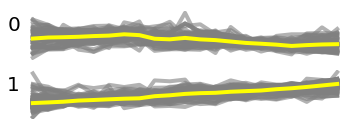

In [15]:
plotting_km_cluster(2)

Number of cluster: 3


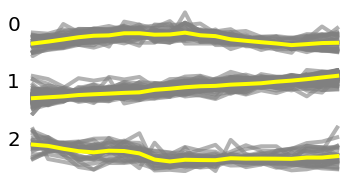

In [16]:
plotting_km_cluster(3)

Number of cluster: 4


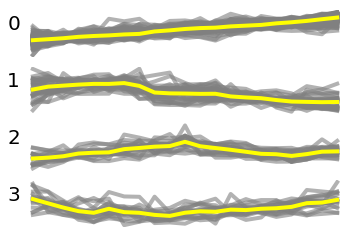

In [17]:
plotting_km_cluster(4)

Number of cluster: 5


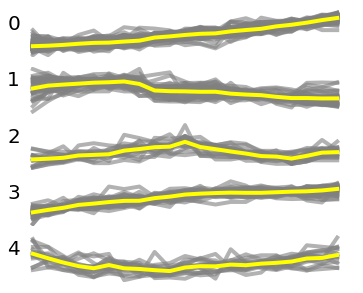

In [18]:
plotting_km_cluster(5)

Number of cluster: 6


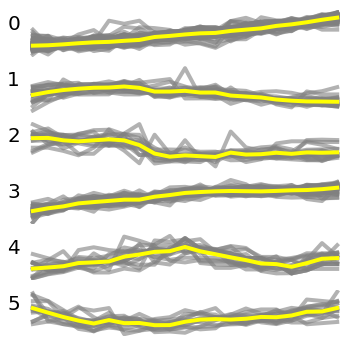

In [19]:
plotting_km_cluster(6)

Number of cluster: 7


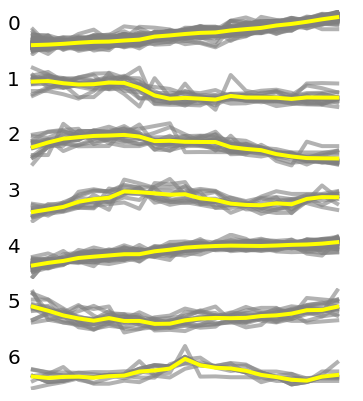

In [20]:
plotting_km_cluster(7)

Number of cluster: 8


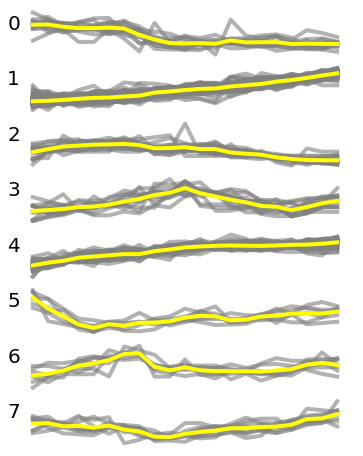

In [21]:
plotting_km_cluster(8)

Number of cluster: 9


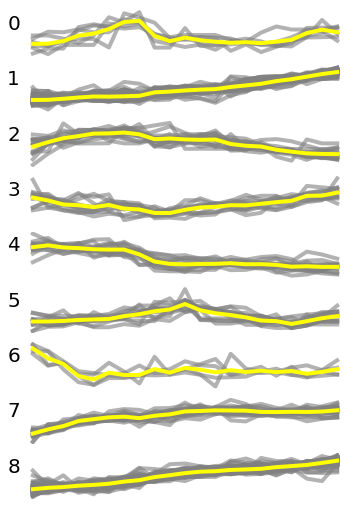

In [22]:
plotting_km_cluster(9)

### The silhouette_score basicaly drop all the way as clustering number increases. If based on the value, I would choose n_clusters = 2. For the sake of exploratorily finding some possible patterns, I decided to choose n_clusters = 4, where the score is relatively high before shape dropping.

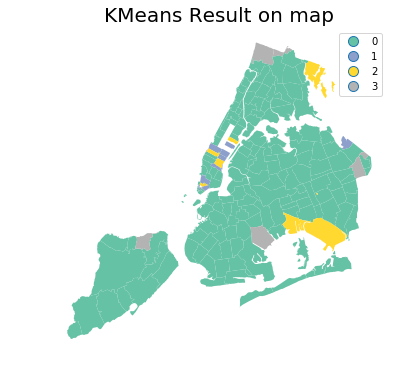

In [23]:
n_clusters = 4
KM = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=999)
KM.fit(X)
centers = KM.cluster_centers_
labels = KM.labels_

KMmap = gpd.GeoDataFrame(pd.concat([nyc.geometry, pd.DataFrame(labels, columns=['label'])], axis=1))
fig, ax = plt.subplots(figsize=(6,6))
KMmap.plot(ax=ax, column='label', categorical=True, cmap='Set2', legend=True) 
ax.set_title('KMeans Result on map', fontsize=20)
ax.set_axis_off()
plt.show()

## hierarchical clustering

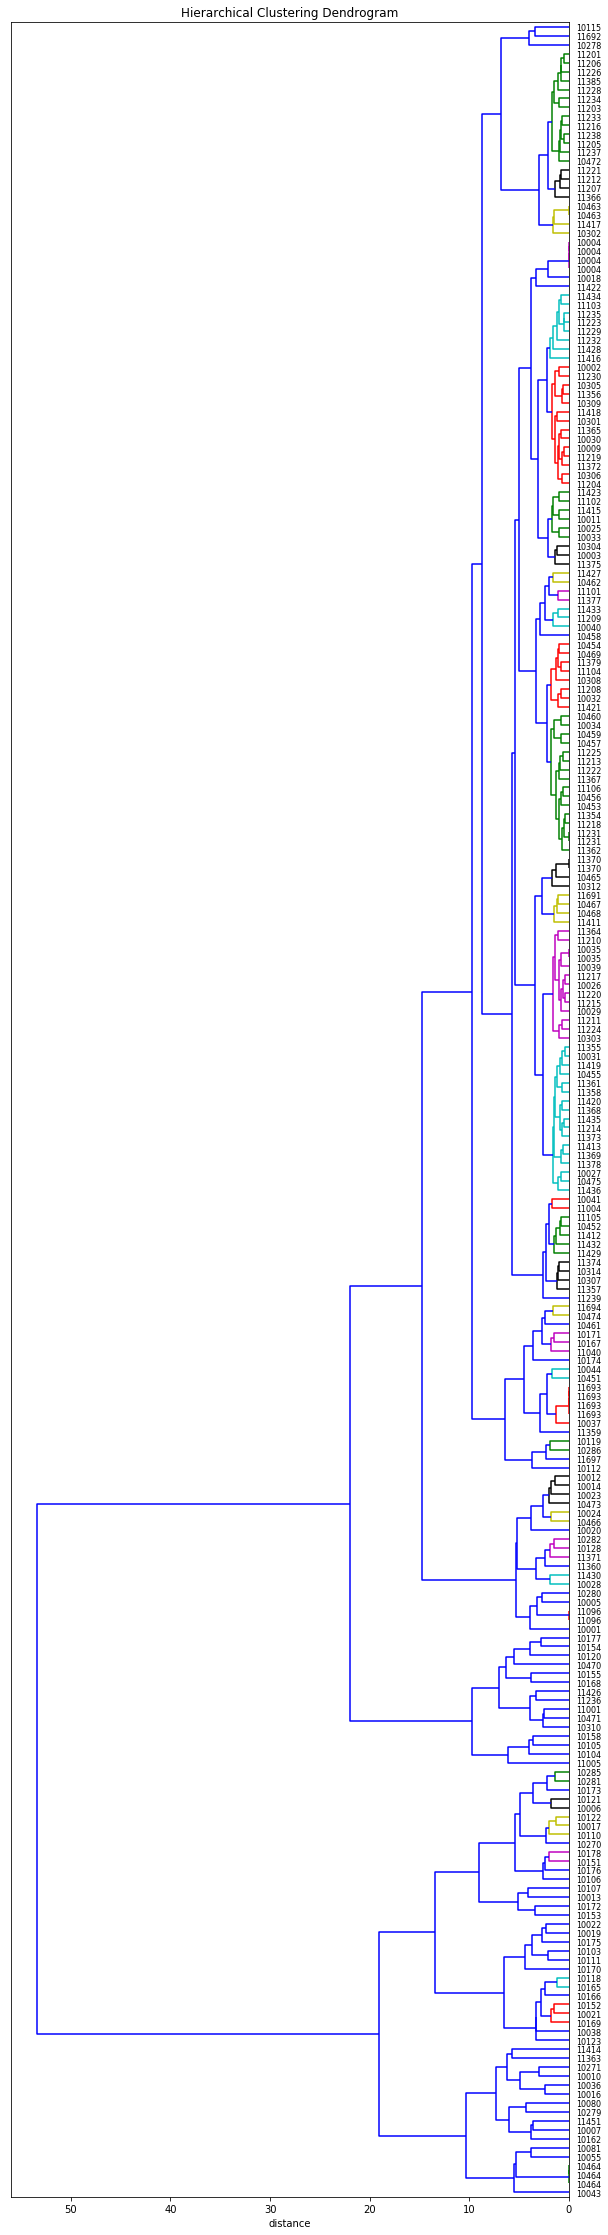

In [31]:
Xh = nyc.drop(['geometry'], axis=1)
Z = sch.linkage(X, 'ward')
plt.figure(figsize=(10, 40))
plt.title('Hierarchical Clustering Dendrogram')
sch.dendrogram(Z, labels = Xh.ZIPCODE.values, orientation='left', leaf_font_size=8, show_leaf_counts=True)
plt.xlabel('distance')
plt.show()

### Figure 3: 
cloropleth of  cluster centers for 5 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

### or maybe like this, depending on which algorithm you use, and how you proceed to preprocess your data and how you cluster it. There is no one correct answer, but general trends should be retrieved.

In [26]:
...

Ellipsis

### Figure 9: 
As figures 3, 5, 7 for hierarchical agglomerative clustering in 7 clusters, with smoothed time series

### And if you use hierarchical clustering and make a dandrogram it may look like this: